In [1]:
import pandas as pd
import numpy as np
from numpy import newaxis
import matplotlib.pyplot as plt
import random
import seaborn as sns
import itertools
import os
from PIL import Image
import math
from matplotlib import gridspec
import matplotlib.collections

from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
import matplotlib.collections

from sklearn.model_selection import *

from tqdm import *
# nice progress bars otherwise
# def tqdm(x):
#     yield x

In [2]:
# TODO, improvement ideas

# TPOT python auto ml
# use log(flux) as input
# investigate highest errors (argmax(xi²))

# kfold integration in place of CV
# TTA
# CNN segmentation cleanup 
# resnet v2 ( https://github.com/myutwo150/keras-inception-resnet-v2/blob/master/inception_resnet_v2.py )
# custom CNN features
# CV2 resize cubic interpolation 

# Serge:
# essayer de remplacer lgb par un Deep NN keras (vu la quantité de donnée)


#done
# lgbm eval rmsle instead of rmse
# add image size as feature



In [3]:
# memory debug function

import sys
# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
mm = sorted([(x, sys.getsizeof(globals().get(x)),"{:,}".format(sys.getsizeof(globals().get(x)))) 
        for x in dir() 
           if not x.startswith('_') 
#         and x not in sys.modules
        and x not in ipython_vars], key=lambda x: x[1], reverse=True)




## data folder set up and test

In [4]:
dataFolder = 'data/mainData/'
plt.ion()

runNameParams = []
runNameParams.append('newSource')
# print(runNameParams)

In [5]:
def read_image(id):
    if id[-4:] == '.npy':
        X = np.load(dataFolder+id)
    elif os.path.isfile(dataFolder+id+'.npy'):
        X = np.load(dataFolder+id + '.npy')
    elif os.path.isfile(dataFolder+id+'-g.csv'):
        X = np.genfromtxt(dataFolder+id+'-g.csv', delimiter=",")
    else:
        X = None

    X = np.float32(X)
    return X


In [6]:
dataFileList = []

directory = os.fsencode(dataFolder)

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".npy") or filename.endswith(".py"): 
        dataFileList.append(filename)
        
print(len(dataFileList))

80306


# Check a few random images 


In [7]:
def drawOneGalaxy(galaxyID):
    oneImageData = read_image(galaxyID)
    print(galaxyID)

    # new image
    fig = plt.figure(figsize=(15,15))
    #set grid spec for the 4 graphs
    gs = gridspec.GridSpec(2, 2, width_ratios=[5, 1], height_ratios=[1,5]) 

    #draw image
    plt.title("raw")
    plt.subplot(gs[2])
    plt.imshow(oneImageData)
    
    # horizontal (top) sum
    plt.subplot(gs[0])
    plt.title(galaxyID)
    plt.plot(oneImageData.sum(axis=0))

    # vertical (bottom-right) sum
    ax = plt.subplot(gs[3])
    ss = np.flip(oneImageData.sum(axis=1),axis=0)
    plt.scatter(x=ss, y=list(range(oneImageData.shape[1])), s=1)
    lines = [[(ss[i-1],i-1),(ss[i],i)] for i in range(1,len(ss))]
    lc = matplotlib.collections.LineCollection(lines)
    ax.add_collection(lc)
    
    #value histogram
    plt.subplot(gs[1])
    plt.hist(oneImageData.reshape(-1), bins=100)
    plt.yscale('log')    
    sns.despine()
    plt.tight_layout()

    #add small log of image
    ax = fig.add_axes([0.02,0.6,.2,.2])
    plt.imshow(np.log(oneImageData-oneImageData.min()+0.00001))

for _ in range(5):
    i = random.randint(0,len(dataFileList))
#     oneImageData = np.load(dataFolder+'1237648704067273096.npy')
#     drawOneGalaxy(dataFileList[i])
    


In [8]:

issuesImages = ['1237658298983055529.npy','1237660634917634181.npy','1237654879654772871.npy','1237654953205170487.npy','1237651249884627014.npy','1237651754022207627.npy',
 '1237654669736018114.npy','1237655471824568727.npy','1237665530643808416.npy','1237658611444088911.npy','1237667255070490937.npy',
 '1237665531177795774.npy','1237645943975837722.npy','1237658425161220139.npy', '1237665129087435003.npy','1237657873792172224.npy',
 '1237660240313778264.npy','1237668298201432152.npy', '1237662264316264518.npy','1237657630042227294.npy','1237651754550624376.npy',
 '1237667211059986578.npy','1237655470208582145.npy']

# for image in issuesImages:
#     drawOneGalaxy(image)

In [9]:
print('test')

test


# ML part

In [10]:
import pandas as pd
import numpy as np
import cv2
from glob import glob
import xgboost as xgb
from keras.applications import *
import lightgbm as lgbm
import scipy
import tensorflow

/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [11]:
def xi2(true,pred,error):
    s=np.mean((true-pred)**2/error**2)
    return s

def normalize_image(Xg):
    Xg -= np.mean(Xg)
    Xg /= np.std(Xg)
    
    return Xg

def crop_image(Xg):
    h,w = Xg.shape
    cy, cx = h//2, w//2
    dy, dx = int(cy*0.75), int(cx*0.75) # crop a bit around center
    Xg = Xg[cy-dy:cy+dy,cx-dx:cx+dx]
    
    return Xg

def img_preprocnoread(Xg, preProcNum = 0):
#    Xg = cleanupImage(id)

    if ( preProcNum != 0):
        if preProcNum & 4: # rotate
            Xg = np.rot90(Xg)
            
        if preProcNum %4 == 1: # vflip
            Xg = np.flip(Xg,0)
        elif preProcNum %4 == 2: # hflip
            Xg = np.flip(Xg,1)
        elif preProcNum %4 == 3: # hflip+vflip
            Xg = np.flip(np.flip(Xg,1),0)

    Xg = np.log1p(Xg - Xg.min())
    Xg = normalize_image(Xg)
    Xg = crop_image(Xg)

    
    if Xg.shape[0] >= 224:
        Xgr = cv2.resize(Xg,(224,224), cv2.INTER_AREA)
    else:
        Xgr = cv2.resize(Xg,(224,224), cv2.INTER_CUBIC)
    
    return Xgr
    
def img_preproc(id, preProcNum = 0):
    Xg = read_image(id)
    return img_preprocnoread(Xg,preProcNum)

runNameParams.append('ReadLog1pNormCrop.75')
# preprocName = "ReadNormCrop.5"
# x = img_preproc('1237662637444694216')
x = img_preproc(dataFileList[random.randint(0,len(dataFileList))])


In [12]:
# plt.imshow(img_preproc('1237662637444694216',0))
# plt.figure()
# plt.imshow(img_preproc('1237662637444694216',1))
# plt.figure()
# plt.imshow(img_preproc('1237662637444694216',2))
# plt.figure()
# plt.imshow(img_preproc('1237662637444694216',5))
# plt.figure()


-0.648829 20.7019
[[-0.14345402 -0.18380356 -0.28998658 -0.37788054 -0.3534275 ]
 [-0.13722998 -0.17829978 -0.28637823 -0.37721148 -0.36211023]
 [-0.12085097 -0.16381618 -0.27688253 -0.37545082 -0.38495949]
 [-0.11069985 -0.15261583 -0.26292104 -0.36172083 -0.38984454]
 [-0.13880593 -0.16158412 -0.22152676 -0.27446523 -0.28437799]]


1

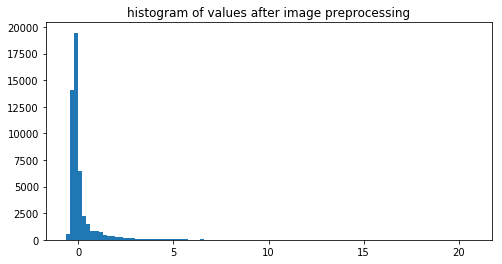

In [13]:
print(x.min(), x.max())
print(x[0:5,0:5])

plt.figure(figsize=(8,4))
plt.title('histogram of values after image preprocessing')
plt.hist(x.reshape(-1), bins=100)

1

### Load pretrained networks

In [14]:
vgg16 = VGG16(weights='imagenet',include_top=True,input_shape=(224,224,3))
r50 = ResNet50(weights='imagenet',include_top=False,input_shape=(224,224,3))

### Read metadata file

In [15]:
df =  pd.read_fwf('metaData.dat', comment = '#')
df.columns = df.iloc[9,:].values
df = df[10:]
df.head()

,SDSS_ID,RA,DEC,D25,redshi,logMst,err_l,GalSize_kpc,D_Mpc,d_pix_kpc
10,1237662635825954925,210.95489999999998,12.64455,0.33113110693986714,0.1029,-99.0,-99.0,42.47806067869379,440.99999325616017,0.8552113203991983
11,1237652947452297303,0.84015,-9.98328,0.5248074948227709,0.0767,11.312,0.016,50.181626715917524,328.7142940929958,0.6374607478101917
12,1237652899137912944,1.0026,-11.17802,0.6165950323262803,0.0383,9.708,0.071,29.440699795795908,164.1428577048438,0.3183148122868964
13,1237661433779716229,211.48905000000002,43.88251,0.7585775667003197,0.0337,9.26,0.062,31.869792393005813,144.4285735487938,0.28008379359836033
14,1237652944786555077,1.48395,16.13445,0.3388441338170015,0.0909,10.7,0.04,38.39840364463448,389.571413397789,0.7554782039377076


In [16]:
df['RA'] = df['RA'].apply(np.float64)
df['DEC'] = df['DEC'].apply(np.float64)
df['D25'] = df['D25'].apply(np.float64)
df['redshi'] = df['redshi'].apply(np.float64)
df['logMstar'] = df['logMst'].apply(np.float64) #renamed
df['err_logMstar'] = df['err_l'].apply(np.float64) #renamed
df['GalSize_kpc'] = df['GalSize_kpc'].apply(np.float64)
df['Distance'] = df['D_Mpc'].apply(np.float64) #renamed
df['d_pix_kpc'] = df['d_pix_kpc'].apply(np.float64)

df['lin_mass'] = np.power(10, df.logMstar)
df['lin_err'] = df['lin_mass'] * np.log(10) * df.err_logMstar

df = df.drop(['logMst','err_l'], axis=1)
df.describe()

,RA,DEC,D25,redshi,GalSize_kpc,d_pix_kpc,logMstar,err_logMstar,Distance,lin_mass,lin_err
count,187742.000000,187742.000000,187742.000000,187742.000000,187742.000000,187742.000000,187742.000000,187742.000000,187742.000000,1.877420e+05,1.877420e+05
mean,184.527190,24.898677,0.445798,0.074652,38.318105,0.620438,9.081941,-1.313631,319.936358,7.877701e+10,4.648110e+09
std,61.620064,19.374103,0.168006,0.040143,18.942158,0.333632,12.706553,11.469736,172.041273,9.461819e+10,5.529011e+09
min,0.008250,-11.252830,0.316228,0.010000,4.034125,0.083111,-99.000000,-99.000000,42.857142,1.000000e-99,-2.279559e-97
25%,152.349938,8.662358,0.346737,0.044100,25.157782,0.366519,10.191000,0.021000,189.000006,1.552387e+10,1.144774e+09
50%,185.824575,23.197910,0.389045,0.069000,35.525868,0.573465,10.693000,0.029000,295.714278,4.931738e+10,2.906879e+09
75%,222.151537,39.835143,0.478630,0.096400,48.283920,0.801189,11.032000,0.041000,413.142858,1.076465e+11,6.027530e+09
max,359.994900,70.133250,10.964781,0.299600,1373.931687,2.490003,12.326000,0.800000,1284.000022,2.118361e+12,1.727792e+11


In [17]:
# df.SDSS_ID[:20].apply(lambda x: x)
df['hasFile'] = df.SDSS_ID.apply(lambda x: os.path.isfile(dataFolder+x+'.npy'))

print("data file present:", len(df[df['hasFile']==True]))
print("data file missing:", len(df[df['hasFile']==False]))

data file present: 80306
data file missing: 107436


### Filter images that have no known mass, no actual image, or with an unknown error

In [18]:
df = df[df.logMstar != -99]
df = df[df.hasFile == True]
df = df[df['lin_err']!=0]
df.describe()

,RA,DEC,D25,redshi,GalSize_kpc,d_pix_kpc,logMstar,err_logMstar,Distance,lin_mass,lin_err
count,78851.000000,78851.000000,78851.000000,78851.000000,78851.000000,78851.000000,78851.000000,78851.000000,78851.000000,7.885100e+04,7.885100e+04
mean,185.303775,25.672447,0.557644,0.058701,38.101843,0.487867,10.558197,0.031070,251.574576,7.898269e+10,4.398954e+09
std,57.111612,18.944782,0.194465,0.032567,19.838329,0.270663,0.654456,0.016953,139.570856,9.624108e+10,5.552716e+09
min,0.009450,-11.238420,0.407380,0.010000,5.248929,0.083111,7.376000,0.001000,42.857142,2.376840e+07,4.756699e+05
25%,154.486425,9.795145,0.436516,0.033800,24.390653,0.280915,10.200000,0.019000,144.857136,1.584893e+10,1.023221e+09
50%,186.753000,24.400580,0.489779,0.052300,35.043089,0.434670,10.692000,0.028000,224.142852,4.920395e+10,2.693666e+09
75%,221.979375,40.093400,0.602560,0.075600,47.500516,0.628319,11.030000,0.039000,323.999992,1.071519e+11,5.603185e+09
max,359.994900,70.133250,10.964781,0.294800,1373.931687,2.450110,12.326000,0.778000,1263.428628,2.118361e+12,1.414535e+11


In [19]:
random.seed(42)

df = df.sample(frac=1).reset_index(drop=True)

In [20]:
df.head()

,SDSS_ID,RA,DEC,D25,redshi,GalSize_kpc,D_Mpc,d_pix_kpc,logMstar,err_logMstar,Distance,lin_mass,lin_err,hasFile
0,1237665226239836324,206.63055,30.02008,0.407380,0.1046,53.122808,448.2857031481607,0.869340,11.025,0.012,448.285703,1.059254e+11,2.926826e+09,True
1,1237671992951767159,206.07855,2.54089,0.436516,0.0725,39.453661,310.714276773589,0.602554,11.000,0.026,310.714277,1.000000e+11,5.986721e+09,True
2,1237666339190014232,19.02330,-0.01491,0.977237,0.0446,54.335565,191.14285175289427,0.370675,11.124,0.019,191.142852,1.330454e+11,5.820621e+09,True
3,1237653502044668058,40.20855,-7.97571,0.602560,0.0268,20.131868,114.85713933195386,0.222737,10.221,0.033,114.857139,1.663413e+10,1.263949e+09,True
4,1237662637986480160,241.07910,9.26749,0.758578,0.0476,45.014900,204.000004700252,0.395608,10.775,0.041,204.000005,5.956621e+10,5.623407e+09,True


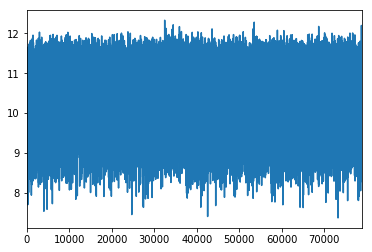

In [21]:
df.logMstar.plot()

In [22]:
print(len(df.SDSS_ID.values))

78851


# Iteration parameters defined here:

- N is the number of galaxies to use for this run
- M is the number of galaxies to train set (rest is holdout)
- chunkSize is the number of galaxies to evaluate at once
- prefixThisRound is the model name, for serialization purposes

In [23]:
N = int(len(df.SDSS_ID.values))
M = int(N*.9)
prefixThisRound = 'sp'
for i in runNameParams:
    prefixThisRound = prefixThisRound + '-' + i

chunkSize = 200
nSplits = 3

# N = 3000 # number of galaxies to take into consideration
# M = 2000 # train vs holdout


# N = int(N*0.01)
# M = int(M*0.01)


In [24]:
ids = df.SDSS_ID.values[:N]
Y = df.logMstar.values[:N]
err = df.err_logMstar.values[:N]
Y_lin = df.lin_mass.values[:N]
err_lin = df.lin_err.values[:N]

In [25]:
print(N)
print(M)
print(chunkSize)
print(prefixThisRound)

78851
70965
200
sp-newSource-ReadLog1pNormCrop.75


In [26]:
# crap instruction to make the auto execution stop here :p

### call img_preproc on all images, per batches of "chunkSize"
### Generate features based on the preprocessed images, pretrained networks and flux densities

In [27]:
def chunkFileName(chunkSize, prefix, chunkNumber):
    fileName = 'Xg3-'+str(chunkSize)+'-'+prefix+'-chunk-' + str(chunkNumber) + '.npy'
    return fileName

In [28]:
prefixThisRound = prefixThisRound + '-model6'

In [29]:
lgbm_params = {
    'boosting_type': 'gbdt',
    'objective': 'regression_l2',
    'nthread': 4,
    #'silent': True,
    'num_leaves': 2**4,
    'learning_rate': 0.01,
    'max_depth': 10,
    'max_bin': 255,
    #'subsample_for_bin': 50000,
    #'subsample': 0.8,
    #'subsample_freq': 1,
    #'colsample_bytree': 0.8,
    #'reg_alpha': 1,
    #'reg_lambda': 0,
    #'min_split_gain': 0.5,
    #'min_child_weight': 1,
    #'min_child_samples': 60,
    #'scale_pos_weight': 1,
    'device' : 'gpu',
    'metric' : 'rmse',
    #'metric' : 'multi_error',
    'verbose':0,          
}

In [30]:
def getFeatures(preProcessingNum):
    Xg3r50 = []
    Xg3vgg16 = []
    postImgFeatures = []
    csize=2
    preImgFeatures = []

    maxChunkNumber = math.ceil(len(ids)/chunkSize)
    chunkStart = 0
    # for chunkStart in tqdm(range(0, 3)):
    for chunkStart in tqdm(range(0, len(ids), chunkSize)):
        curChunk = int((chunkStart//chunkSize))
        valuesInThisChunk = min(chunkStart+chunkSize,len(ids))-chunkStart

        Xg_ = []
        pre_ex_ = []

        # preprocess the image and collect some raw image stats
        for i in range(chunkStart, chunkStart+valuesInThisChunk):
            X = read_image(ids[i])
            Xg_.append(img_preprocnoread(X, preProcessingNum))
            pre_ex_.append([
                X.sum(),
                X.min(),
                X.max(),
                X.mean(),
                X.std(),
                X[X.shape[0]//2,X.shape[1]//2],
                np.mean(X[X.shape[0]//2-csize:X.shape[0]//2+csize,X.shape[1]//2-csize:X.shape[1]//2+csize]), # mean center
                X.shape[0], 
            ])

        # reformat the postprocessing
        pre_ex = np.stack(pre_ex_)
        Xg = np.stack(Xg_)

        # collect some post processing stats
        post_ex = np.hstack([
            np.sum(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
            np.min(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
            np.max(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
            np.mean(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
            np.std(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
            Xg[:,112,112].reshape(valuesInThisChunk,1),       # center
            np.mean(Xg[:,112-csize:112+csize,112-csize:112+csize].reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,-1) # mean center
            ])

        Xg3 = np.zeros((valuesInThisChunk,224,224,3))
        Xg3[:,:,:,:] = Xg.reshape(valuesInThisChunk,224,224,1)

        # do r50 prediction
        Xg3r50_ = r50.predict(Xg3).reshape(valuesInThisChunk, 2048)
        Xg3vgg16_ = vgg16.predict(Xg3)


        if chunkStart == 0:
            Xg3r50 = Xg3r50_
            Xg3vgg16 = Xg3vgg16_
            preImgFeatures = pre_ex
            postImgFeatures = post_ex
        else:
            Xg3r50 = np.concatenate([Xg3r50,Xg3r50_], axis=0)
            Xg3vgg16 = np.concatenate([Xg3vgg16,Xg3vgg16_], axis=0)
            preImgFeatures = np.concatenate([preImgFeatures,pre_ex], axis=0)
            postImgFeatures = np.concatenate([postImgFeatures,post_ex], axis=0)

    postImgFeatureNames = ['norm.flux.sum', 'norm.flux.min',
                           'norm.flux.max', 'norm.flux.mean', 
                           'norm.flux.std', 'center.flux', 
                           'aroundCenter.flux']
    preImgFeatureNames = ['pre.flux.sum', 'pre.flux.min', 
                          'pre.flux.max', 'pre.flux.mean',
                          'pre.flux.std', 'pre.center.flux',
                          'pre.aroundCenter.flux', 'width']


    Xg3 = None
    Xg = None
    X = None

    Distance = df.Distance.values[:N].reshape(N,1)

    Xg3f = np.hstack ( ( 
            Xg3r50, 
            Xg3vgg16, 
            Distance,
            1/Distance,
            Distance**2,
            1/(Distance**2),
            Distance**3,
            1/(Distance**3),
            np.log(Distance),
            1/np.log(Distance),
            np.log(Distance**2),
            1/np.log(Distance**2),
            np.log(Distance)**2,
            1/np.log(Distance)**2,
            preImgFeatures,
            postImgFeatures
            ) )

    distanceNames = ['D', '1/D', 'D**2', '1/D**2', 'D**3', '1/D**3', 'log(D)', '1/log(D)', 'log(D**2)', 'log(1/D**2)', 'log(D)**2', '1/log(D)**2' ]

    # extraImgFeatureNames = ['norm.flux.sum', 'norm.flux.min', 'norm.flux.max', 'norm.flux.mean', 'norm.flux.std', 'center.flux', 'aroundCenter.flux']

    Xg3fNames = ( [prefixThisRound+'.r50.' + str(i) for i in range(Xg3r50.shape[1])]
                + [prefixThisRound+'.vgg16.' + str(i) for i in range(Xg3vgg16.shape[1])] 
                + [prefixThisRound+'.'+ n for n in distanceNames]
                + [prefixThisRound+'.'+ n for n in preImgFeatureNames]
                + [prefixThisRound+'.'+ n for n in postImgFeatureNames])

    print(len(Xg3fNames), Xg3f.shape)
    
    return Xg3f, Xg3fNames
    

In [31]:
def getModelsWithCV(trainSet, YSet):
    kf = KFold(n_splits=nSplits,shuffle=True, random_state=220477)

    cvtrainpreds = np.zeros([len(Xg3f),nSplits])
    models = []
    xis, linxis = [],[]
    counter = 0
    for tix, vix in kf.split(trainSet):
        X_train, X_test = trainSet[tix], trainSet[vix]
        Y_train, Y_test = YSet[tix], YSet[vix]

        lgb_train = lgbm.Dataset(X_train, Y_train)
        lgb_eval = lgbm.Dataset(X_test, Y_test)

        gbm = lgbm.train(lgbm_params,
                           lgb_train,
                           num_boost_round=20000,
                           valid_sets=[lgb_train,lgb_eval],  # eval training data
                           verbose_eval=100,
                           early_stopping_rounds=100
                        )
        models.append(gbm)

        p = gbm.predict(X_test)
        chiSq = xi2(Y_test,p,err[vix])
        linChiSq = xi2(10**Y_test,10**p,err_lin[vix])
        xis.append(chiSq)
        linxis.append(linChiSq)
        print(counter,chiSq,linChiSq)    

        cvtrainpreds[vix,counter] = p
        counter = counter+1
        
    return models, cvtrainpreds, xis, linxis

# models, cvtrainpreds, xis, linxis = getModels(Xg3f[:M], Y[:M])

# print(models, cvtrainpreds)

# print(xis, linxis)


In [32]:
def getModelsNoCV(trainSet, YSet, errSet, errlinSet):
    cvtrainpreds = np.zeros([len(trainSet),1])
    models = []
    xis, linxis = [],[]
    counter = 0

    tix, vix = list(range(0,int(len(trainSet)*0.9))), list(range(int(len(trainSet)*0.9),len(trainSet)))
    
    X_train, X_test = trainSet[tix], trainSet[vix]
    Y_train, Y_test = YSet[tix], YSet[vix]

    lgb_train = lgbm.Dataset(X_train, Y_train)
    lgb_eval = lgbm.Dataset(X_test, Y_test)

    gbm = lgbm.train(lgbm_params,
                       lgb_train,
                       num_boost_round=20000,
                       valid_sets=[lgb_train,lgb_eval],  # eval training data
                       verbose_eval=100,
                       early_stopping_rounds=100
                    )
    models.append(gbm)

    p = gbm.predict(X_test)
    chiSq = xi2(Y_test,p,errSet[vix])
    linChiSq = xi2(10**Y_test,10**p,errlinSet[vix])
    xis.append(chiSq)
    linxis.append(linChiSq)
    print(counter,chiSq,linChiSq)    

    cvtrainpreds[vix,counter] = p
    counter = counter+1
        
    return models, cvtrainpreds, xis, linxis


In [33]:
reloadImagesAndPreprocess = 0

numPreprocessing = 8
nSplits = 1
ttaPredictions = np.zeros([numPreprocessing,nSplits,N-M])


if reloadImagesAndPreprocess == 1:
    for curTTA in range(numPreprocessing):
        a, Xg3fNames = getFeatures(curTTA)

        if curTTA == 0:
            trainXg3fStacked = a[:M]
            trainYStacked = Y[:M]
            testXg3fStacked = a[M:]
            testYStacked = Y[M:]
            trainErrStacked = err[:M]
            trainErrlinStacked = err_lin[:M]
            testErrStacked = err[M:]
            testErrlinStacked = err_lin[M:]
        else:
            trainXg3fStacked = np.vstack([trainXg3fStacked,a[:M]])
            trainYStacked = np.hstack([trainYStacked,Y[:M]])
            testXg3fStacked = np.vstack([testXg3fStacked,a[M:]])
            testYStacked = np.hstack([testYStacked,Y[M:]])
            trainErrStacked = np.hstack([trainErrStacked,err[:M]])
            trainErrlinStacked = np.hstack([trainErrlinStacked, err_lin[:M]])
            testErrStacked = np.hstack([testErrStacked,err[M:]])
            testErrlinStacked = np.hstack([testErrlinStacked, err_lin[M:]])

    np.save(prefixThisRound + 'tr' + str(numPreprocessing) + '.npy', trainXg3fStacked)
    np.save(prefixThisRound + 'try' + str(numPreprocessing) + '.npy', trainYStacked)
    np.save(prefixThisRound + 'te' + str(numPreprocessing) + '.npy', testXg3fStacked)
    np.save(prefixThisRound + 'tey' + str(numPreprocessing) + '.npy', testYStacked)
    np.save(prefixThisRound + 'tre' + str(numPreprocessing) + '.npy', trainErrStacked)
    np.save(prefixThisRound + 'trle' + str(numPreprocessing) + '.npy', trainErrlinStacked)
    np.save(prefixThisRound + 'tee' + str(numPreprocessing) + '.npy', testErrStacked)
    np.save(prefixThisRound + 'tele' + str(numPreprocessing) + '.npy', testErrlinStacked)
else:
    trainXg3fStacked = np.save(prefixThisRound + 'tr' + str(numPreprocessing) + '.npy')
    trainYStacked = np.save(prefixThisRound + 'try' + str(numPreprocessing) + '.npy')
    testXg3fStacked = np.save(prefixThisRound + 'te' + str(numPreprocessing) + '.npy')
    testYStacked = np.save(prefixThisRound + 'tey' + str(numPreprocessing) + '.npy')
    trainErrStacked = np.save(prefixThisRound + 'tre' + str(numPreprocessing) + '.npy')
    trainErrlinStacked = np.save(prefixThisRound + 'trle' + str(numPreprocessing) + '.npy')
    testErrStacked = np.save(prefixThisRound + 'tee' + str(numPreprocessing) + '.npy')
    testErrlinStacked = np.save(prefixThisRound + 'tele' + str(numPreprocessing) + '.npy')




  0%|          | 0/395 [00:00<?, ?it/s]

3075 (78851, 3075)


100%|██████████| 395/395 [11:08<00:00,  1.39s/it]


3075 (78851, 3075)


100%|██████████| 395/395 [11:10<00:00,  1.38s/it]


3075 (78851, 3075)


100%|██████████| 395/395 [11:09<00:00,  1.39s/it]


3075 (78851, 3075)


100%|██████████| 395/395 [11:10<00:00,  1.39s/it]


3075 (78851, 3075)


100%|██████████| 395/395 [11:09<00:00,  1.38s/it]


3075 (78851, 3075)


100%|██████████| 395/395 [11:10<00:00,  1.40s/it]


3075 (78851, 3075)


100%|██████████| 395/395 [11:10<00:00,  1.39s/it]


3075 (78851, 3075)


In [34]:
ezerzer

NameError: name 'ezerzer' is not defined

In [ ]:
models, cvtrainpreds, xis, linxis = getModelsNoCV(trainXg3fStacked, trainYStacked, trainErrStacked, trainErrlinStacked)

ppreds = np.zeros([len(models),testXg3fStacked.shape[0]])
for i, m in zip(range(len(models)),models):
    mp = m.predict(testXg3fStacked)
    ppreds[i] = mp

cvpred = ppreds.mean(axis=0)

print("Iteration : {}".format(curTTA))
chiSq = xi2(testYStacked,cvpred,testErrStacked)
linChiSq = xi2(10**testYStacked,10**cvpred,testErrlinStacked)
print(chiSq)
print(linChiSq)

# ttaPredictions[curTTA] = ppreds
    

In [ ]:
# print(M)
# print(trainXg3fStacked.shape)
# testXg3fStacked.shape
# ttaPredictions.shape
# ppreds.shape

mpred = ppreds.reshape((numPreprocessing,-1)).mean(axis=0)
chiSq = xi2(Y[M:],mpred,err[M:])
linChiSq = xi2(10**Y[M:],10**mpred,err_lin[M:])
print(chiSq)
print(linChiSq)


In [ ]:
print(ttaPredictions.shape)
print(ttaPredictions[:,:,0])

In [ ]:
cvpred = ttaPredictions.mean(axis=0).mean(axis=0)

print("Iterations : {}".format(nSplits*(curTTA+1)))
chiSq = xi2(Y[M:],cvpred,err[M:])
linChiSq = xi2(10**Y[M:],10**cvpred,err_lin[M:])
print(chiSq)
print(linChiSq)

# ttaPredictions[curTTA] = ppreds


In [ ]:
for i in range(ttaPredictions.shape[0]):
    cvpred = ttaPredictions[i].mean(axis=0)
    chiSq = xi2(Y[M:],cvpred,err[M:])
    linChiSq = xi2(10**Y[M:],10**cvpred,err_lin[M:])
    print("Iteration {}: x²:{:2f} lin x²:{:2f} [".format(i,chiSq,linChiSq), end='')
    
    for j in range(ttaPredictions.shape[1]):
        cvpred = ttaPredictions[i,j]
        chiSq = xi2(Y[M:],cvpred,err[M:])
        linChiSq = xi2(10**Y[M:],10**cvpred,err_lin[M:])
        print("{:2f} {:2f} ".format(chiSq, linChiSq), end='')
        
    print("]")


In [ ]:
cvpred = ttaPredictions.mean(axis=0).mean(axis=0)

chiSq = xi2(Y[M:],cvpred,err[M:])
linChiSq = xi2(10**Y[M:],10**cvpred,err_lin[M:])
print("Values over all {} iterations : {},  {}".format(nSplits*(curTTA+1), chiSq, linChiSq))


In [ ]:
# print(ttaPredictions.mean(0).mean(0)[3])
# print(ttaPredictions[:,:,3])

In [ ]:
diehere

In [ ]:
Xg3f.shape

In [ ]:
a = Xg3f
b = Xg3f

b = np.vstack([a,b])
b = np.vstack([a,b])
b = np.vstack([a,b])
b.shape

In [ ]:
plt.imshow(img_preproc('1237662637444694216',0))
plt.figure()
plt.imshow(img_preproc('1237662637444694216',1))
plt.figure()
plt.imshow(img_preproc('1237662637444694216',2))
plt.figure()
plt.imshow(img_preproc('1237662637444694216',5))
plt.figure()


In [ ]:
print(Xg3f.shape)
print(df.shape)

t1 = df.SDSS_ID.values[:N].reshape(N,1)
t2 = Xg3f[:N,:]
t3 = np.concatenate((t1,t2), axis=1)
np.save(prefixThisRound+str(N), t3)
np.save(prefixThisRound+str(N) + 'featurenames', Xg3fNames)
del t1, t2, t3

In [ ]:

# if os.path.isfile(prefixThisRound +str(N)+'.npy'):
#     t3 = np.load(prefixThisRound+str(N)+'.npy')
#     Xg3fNames = np.load(prefixThisRound+str(N) + 'featurenames' + '.npy', )
# Xg3f = t3[:,1:]
# Xg3f.shape

In [ ]:
# Xg3f = t3[:,1:]
# Xg3f.shape

### Generate the train/test datasets for lgbm regression

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(Y[M:]-cvpred)

In [ ]:
badID = np.argmax(Y[M:]-cvpred)
print(Y[badID])
print(df.loc[badID])
# df['cvpred'] = cvpred
# df['lincvpred'] = 10**cvpred
# df['deltapred'] = abs(Y[M:]-cvpred)
# df['lindeltapred'] = 10**Y[M:]-10**cvpred

drawOneGalaxy(df.SDSS_ID[badID])


In [ ]:
print(prefixThisRound)

# df.to_csv(prefixThisRound + '-CVResultDF.csv')

In [ ]:
df.sort_values(by='deltapred', ascending=False).iloc[:20,:]

In [ ]:
sns.jointplot(x=Y, y=cvpred, kind='reg')
plt.title('log reg')
sns.jointplot(x=Y, y=cvpred, kind='resid')
plt.title('log residuals')

sns.jointplot(x=10**Y, y=10**cvpred, kind='reg')
plt.title('log reg')
sns.jointplot(x=10**Y, y=10**cvpred, kind='resid')
plt.title('log residuals')


In [ ]:
plt.plot(Xg3f[:,3067])
# plt.hist(Xg3f[:,3067],bins=100)
np.argmax(Xg3f[:,3067])
df.iloc[59964,:]

drawOneGalaxy('1237665015776477192')

# Model is trained, values are obtained, saving and result analysis below

In [ ]:
# break here, save the stuff below

In [ ]:
arr = model.feature_importance()
print(arr.shape)
np.argmax(arr)
# print(arr)

In [ ]:
fimport = list(zip(arr, Xg3fNames))
sorted(fimport, key=lambda x: x[0], reverse=True)[:50]

In [ ]:
sns.jointplot(x=Y[M:], y=pred, kind='kde')
plt.title('log kde')
sns.jointplot(x=Y[M:], y=pred, kind='reg')
plt.title('log reg')
sns.jointplot(x=Y[M:], y=pred, kind='resid')
plt.title('log residuals')


sns.jointplot(x=10**Y[M:], y=10**pred, kind='kde')
plt.title('lin kde')
sns.jointplot(x=10**Y[M:], y=10**pred, kind='reg')
plt.title('lin joint')
sns.jointplot(x=10**Y[M:], y=10**pred, kind='resid')
plt.title('lin joint')
# plt.scatter(x=10**Y[M:], y=10**pred)


In [ ]:
df[df['logMstar']>=12]

In [ ]:
print(df.shape)
print(pred.shape)

In [ ]:
plt.plot(10**Y[M:]-10**pred)
worstID = np.argmax(10**Y[M:]-10**pred)

print(Y[M+worstID], pred[worstID])
print(10**Y[M+worstID], 10**pred[worstID])
print(df.loc[M+worstID,:]) # 1237664105244524770, 1237661851469611060 1237654626789163411

# pred[worstID] = Y[M+worstID]

drawOneGalaxy(df.loc[M+worstID,'SDSS_ID'])

In [ ]:
# Warning: predictions from here on will contain data from training set: 
pred = model.predict(Xg3f[:])



In [ ]:
pred.shape

In [ ]:
df['pred'] = pred
df['lin_pred'] = 10**pred

In [ ]:
plt.plot(Y[:]-pred)

In [ ]:
sns.jointplot(data=df, x='lin_pred', y='lin_mass', kind='reg')
plt.title('lin kde')
